# 2022-07-14 • Not directly connected but detected -- with self-bug

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin (see previous nb).

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    to_record = [1, 801],
);
# dumps(p)

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

In [8]:
import PyPlot

In [9]:
using VoltoMapSim.Plot

## Conntest

In [11]:
m = 1  # ID of recorded excitatory neuron
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

In [30]:
length(ii.unconnected_neurons)

964

In [14]:
perf = evaluate_conntest_perf(v, ii.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:29


In [15]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

So we're investigating those 15% false positives, which would be 5% if directly-unconnected spiketrains were not related to the voltage signal.

In [21]:
signif_unconn = findall(perf.p_values.unconn .< p.evaluation.α)
# These are indices in `ii.unconnected_neurons`

6-element Vector{Int64}:
  1
  3
  4
 15
 21
 35

Note that these are indices in `unconnected_neurons`, not global neuron IDs.

In [23]:
length(signif_unconn) / p.evaluation.N_tested_presyn

0.15

(The eval_conntest_perf function takes the first N_tested_presyn = 40 of the spiketrains it's given).

## STAs

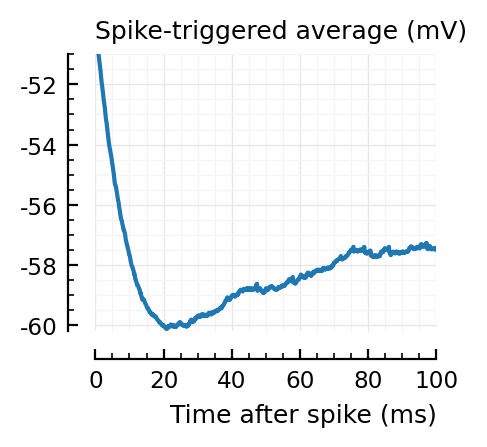

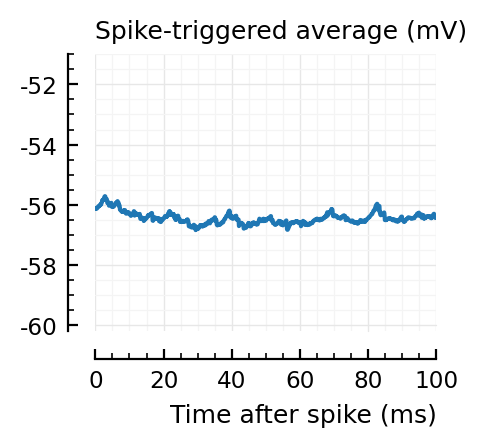

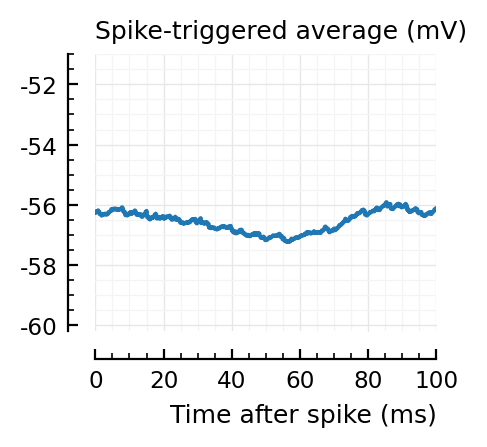

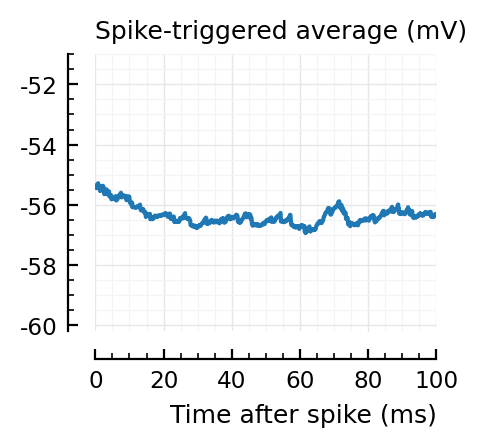

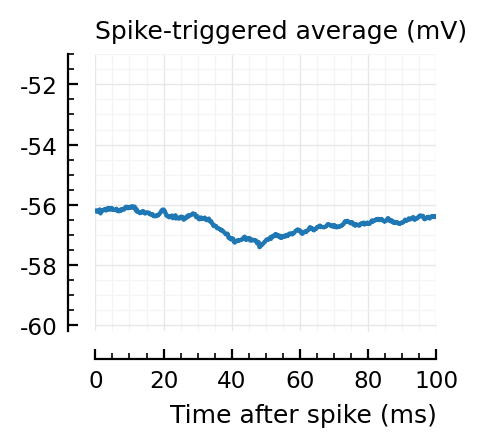

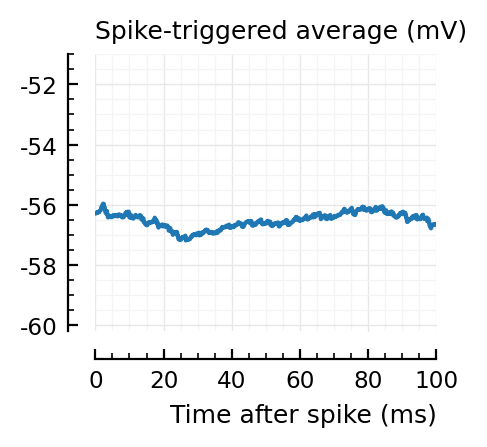

In [29]:
for i in signif_unconn
    _, ax = plt.subplots(figsize=(2.2, 1.8))
    plotSTA(v, ii.spiketrains.unconn[i], p; ax, ylim = (-60.2, -51))
end

A bug: the first "unconnected" one (`1`) is the neuron itself.

## Fixed self bug

Editing `input_info` and redoing the above.

In [12]:
ii = get_input_info(m, s, p);

(Should have given this another name and not overwritten the previous)

In [13]:
length(ii.unconnected_neurons)

963

In [14]:
perf = evaluate_conntest_perf(v, ii.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:01:00m


In [15]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

In [16]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)]

6-element Vector{Int64}:
  4
  5
 14
 16
 22
 37

These are now global neuron IDs -- less confusing to work with.

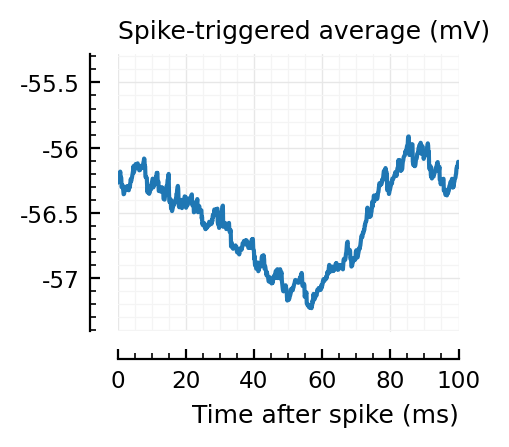

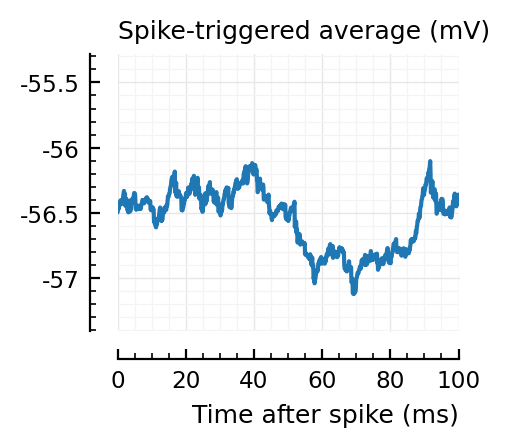

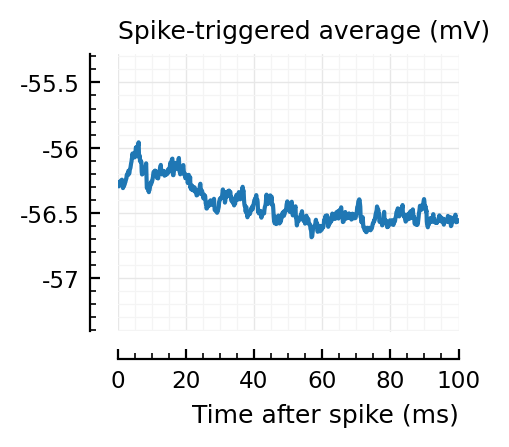

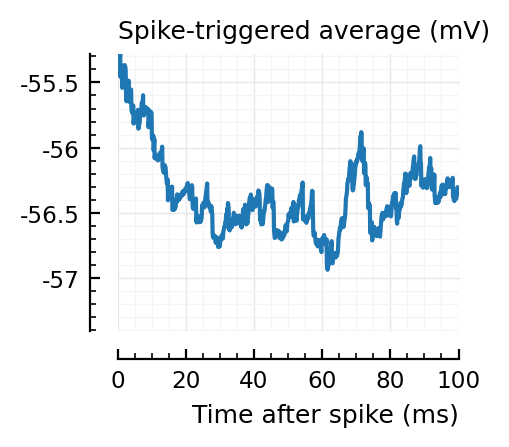

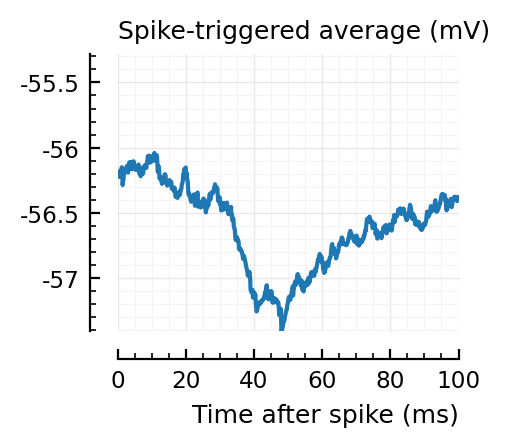

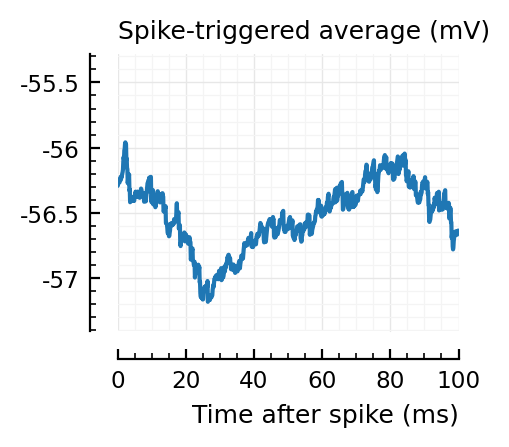

In [54]:
STAs = [calc_STA(v, s.spike_times[n], p) for n in signif_unconn]
ylim = [minimum([minimum(S) for S in STAs]), maximum([maximum(S) for S in STAs])] ./ mV
for n in signif_unconn
    _, ax = plt.subplots(figsize=(2.2, 1.8))
    plotSTA(v, s.spike_times[n], p; ax, ylim)
end

We expect 2/6 (so 2 / 40 tested, i.e. 5%) to change, depending on shuffle.

So let's try another test.  
We do need to set the rng seed manually as the test sets it for reproducibility.

In [63]:
p2 = @set p.evaluation.rngseed = 1;

In [64]:
perf2 = evaluate_conntest_perf(v, ii.spiketrains, p2);

Testing connections: 100%|██████████████████████████████| Time: 0:01:04


In [65]:
perf2.detection_rates

(TPR_exc = 0.115, TPR_inh = 1, FPR = 0.125)

In [66]:
signif_unconn2 = ii.unconnected_neurons[findall(perf2.p_values.unconn .< p.evaluation.α)]

5-element Vector{Int64}:
  4
 14
 16
 22
 37

In [67]:
signif_unconn

6-element Vector{Int64}:
  4
  5
 14
 16
 22
 37

So all except `5` are common between both shuffle seeds.